In [ ]:
import os
import PIL
import math
import yaml
import torch
import logging
import requests
import numpy as np
import torch.nn as nn
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as transforms
from src.tools.layers.bert import BertConfig
from src.pipelines.uni_pipeline import get_transform_vit_default
%matplotlib inline


caption_pipeline = './images/caption_pipeline.png'
vit_pipeline = './images/ViTCAP.png'

### This script provides simple example loading the pre-trained ViTCAP for image captioning task. 
Note: as ViTCAP is still under review and I'm also heavily occupied by some job interviews, the official training and evaluation script will be provided to public later. As ViTCAP does not need any object detector for pre-processing, it is rather easy to be chipped in for other tasks, e.g., COCO_Captioning for evaluations and etc.

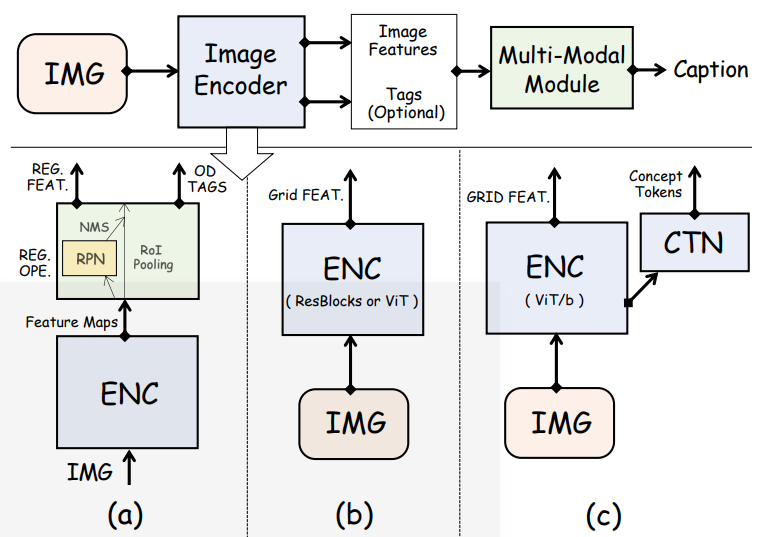

In [2]:
Image(filename=caption_pipeline)

### Some quick introduction about ViTCAP:

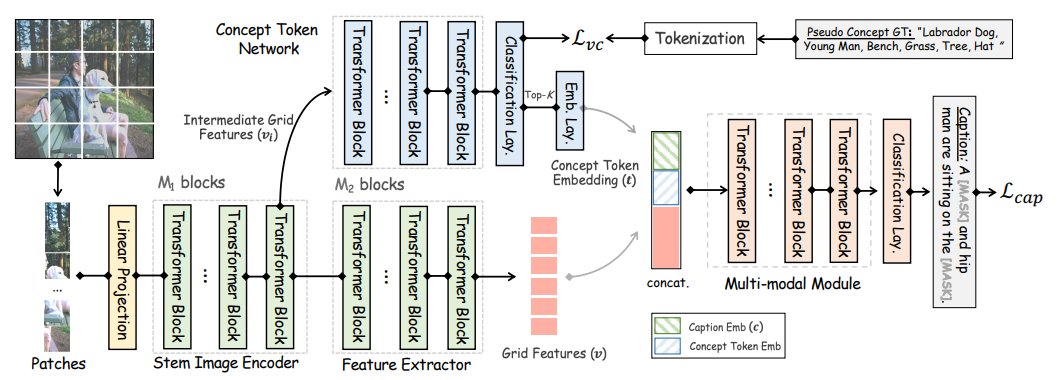

In [3]:
Image(filename=vit_pipeline)

In [4]:
# cocnept pre-trained ViT checkpoint: 
# VL pre-trained + COCO fine-tuned + CIDEr reward optimzed + VinVL Distilled checkpoint (Note this is a two-stream architecture): (COCO-caption CIDEr 138.6)

In [4]:
# Image Captioning model wrapper
class ImageCaptioning(nn.Module):
    def __init__(self,
                 model,
                 test_extra_input=None,
                 tokenizer=None,
                 bert_tokenizer=None,
                 image_encoder=None,
                 cfg=None,
                 ):
        super().__init__()
        self.module = model
        self.iter = 0
        self.tokenizer = tokenizer
        self.bert_tokenizer = bert_tokenizer
        self.test_extra_input = test_extra_input
        self.image_encoder = image_encoder
        self.cfg = cfg
#         self.acc = MultiLabelAccuracy()
#         self.map = mAPMeter()

        if cfg.pert_img_prob is not None and cfg.pert_img_prob > 0:
            # we need an image text matching loss on the pooled output
            # number of relationship is always 1, we use BCE loss
            self.seq_relationship = nn.Linear(model.bert.pooler.dense.weight.shape[0], 1)
            assert self.cfg.mask_type != 'seq2seq', 'matching loss is useless'
        else:
            self.seq_relationship = None

        self.category = cfg.category
        if self.category == 'vinvl':
            self.vocab = self.tokenizer['idx_to_label']
        else:
            self.vocab = self.bert_tokenizer.ids_to_tokens

    def construct_attn_mask(self, data):
        img_feats = data['img_feats']
        input_ids = data['input_ids']
        attention_mask = data['attention_mask']
        batch_size = img_feats.shape[0]

        num_img_feats = img_feats.shape[1]
        num_token = input_ids.shape[-1]
        device = input_ids.device
        top_right = torch.ones((batch_size, num_token, num_img_feats), device=device)
        if self.cfg.mask_type == 'seqbid':
            mask_type = data.pop('mask_type')
            bottom_left = torch.ones((batch_size, num_img_feats, num_token), device=device)
            # if mask_type is 1, it is seq2seq and we need to zero it out
            bottom_left[mask_type] = 0
        elif self.cfg.mask_type in ['seq2seq', 'seq2seq_off']:
            bottom_left = torch.zeros((batch_size, num_img_feats, num_token), device=device)
        else:
            assert self.cfg.mask_type == 'bidirectional'
            bottom_left = torch.ones((batch_size, num_img_feats, num_token), device=device)
            if attention_mask.dim() == 2:
                attention_mask = attention_mask.unsqueeze(dim=1)
                attention_mask = attention_mask.expand(batch_size, num_token, num_token)
        bottom_right = torch.ones((batch_size, num_img_feats, num_img_feats), device=device)
        bottom = torch.cat((bottom_left, bottom_right), dim=2)

        top = torch.cat((attention_mask, top_right), dim=2)
        full_attention_mask = torch.cat((top, bottom), dim=1)
        data['attention_mask'] = full_attention_mask

    def forward(self, data):

        data = dict(data.items())
        
        # this is required in test, but not in train
        data.pop('key')
        data['gen_tag_ratio'] = 1

        assert self.image_encoder
        assert 'img_feats' not in data
        data['img_feats'] = self.image_encoder(data)
        
        data.pop('image')
        self.construct_attn_mask(data)

        # Note: this wrapper only contains inference code, refer XX_captioning_uni_pipelineXX.py for full code
        if self.cfg.use_cbs:
            data.update({
                'min_constraints_to_satisfy': 2,
                'use_cbs': True,
            })

        data.update(self.test_extra_input)
        result = self.module(**data)

        return result

In [5]:
# parameter loading
with open(r'./yaml/distill_caption_uni_pipeline_debug.yaml') as file:
    cfg = yaml.full_load(file)
    
    
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

cfg['param'].update(cfg['all_test_data'])

# update some value
cfg['param'].update({
    'mask_type': 'seq2seq',
    'max_seq_a_length': 40,
    'max_seq_length': 70,
    'add_od_labels': True,
    'od_label_conf ': 0.2,
    'drop_out': 0.1,
    'tie_weights': True,
    'label_smoothing': 0.1,
    'img_layer_norm_eps': 1e-5,
    'max_img_seq_length': 50,
    'max_gen_length': 20,
    'output_isvalid': False,
    'max_masked_tokens': 3,
    'cider_cached_tokens': 'data/coco_caption/gt/coco-train-words.p',
    'num_beams': 1,
    'mask_prob': 0.15,
    'replace_by_mask_prob': 0.8,
    'replace_by_rand_prob': 0.1,
    'temperature': 1,
    'top_k': 0,
    'top_p': 1,
    'gradient_clip': 1.,
    'optimizer_type': 'MAdamW',
    'bias_no_weight_decay': True,
    'ln_no_weight_decay': True,
    'unique_labels_on': False,
    'scheduler_type': 'linear',
    'pad_to_max': True,
    'no_sort_by_conf': False,
    'ignore_project_image': False,
    'real_text_a_in_test': False,
    'pert_img_prob': None,
})

cfg = Struct(**cfg['param'])

In [6]:
cfg.__dict__

{'data': 'TaxCocoCaptionSmall',
 'drop_out': 0.1,
 'net': 'B',
 'mask_type': 'seq2seq',
 'tokenizer_file': 'vinvl_label.json',
 'topk': 50,
 'train_shuffle': False,
 'basemodel': './output/Jacob_Tagger_TaxCCSBUCocoVGCap_B_Vilt_ViT_16_384_20_epoch_lr_5e-5_BS_1024_loss_focal_crop_0.08_bert_category/model_final.pt',
 'clip_checkpoint': '/home/ubuntu/.cache/clip/ViT-B-16.pt',
 'text_encoder_type': './yaml/VILT-L12-H784-uncased_16_384',
 'teacher_encoder_type': './data/vinvl/captioning_vinvl_base',
 'max_img_seq_length': 50,
 'image_encoder_type': 'VitEmb_vit_base_patch16_384',
 'crop_pct': 1.0,
 'base_lr': 0.0001,
 'lr_multiplier': 0.0,
 'split_blocks': 4,
 'monitor_after': True,
 'test_crop_size': 384,
 'train_crop_size': 384,
 'multi_scale': False,
 'multi_crop': False,
 'scale2': 192,
 'scale3': 96,
 'multi_crop_scale': False,
 'num_scale2': 2,
 'num_scale3': 4,
 'dist_url_tcp_port': 12345,
 'train_transform': 'clip_vit',
 'use_img_layernorm': False,
 'expid': 'TaxCocoCaption_B_Vilt_Vin

In [7]:
# Load ViTCAP model

# @property
def tag_vocab():
    assert op.isfile(cfg.tokenizer_file)
    tag_vocab = json.load(open(cfg.tokenizer_file))
    return tag_vocab


# @property
def get_tokenizer(cfg):
    from src.tools.layers.bert import BertTokenizer
    tokenizer = BertTokenizer.from_pretrained(
       cfg.text_encoder_type, do_lower_case=True)
    return tokenizer
    

config = BertConfig.from_pretrained(
    # this class does not support a separate text encoder and thus
    # text_encoder_type here means the joint fusion encoder
    cfg.text_encoder_type,
    num_labels=2,
    finetuning_task='image_captioning',
)


if 'vit' in cfg.text_encoder_type:
    # this is just to make sure we are using the right variables for vit model
    assert cfg.drop_out == 0

config.img_feature_type = 'frcnn'
config.hidden_dropout_prob = cfg.drop_out
config.loss_type = 'classification'
config.tie_weights = False
config.freeze_embedding = False
config.label_smoothing = False
config.drop_worst_ratio = 0
config.drop_worst_after = 0
config.img_feature_dim = cfg.img_feature_dim
config.use_img_layernorm = cfg.use_img_layernorm
config.img_layer_norm_eps = 0
config.net = cfg.image_encoder_type[len('VitEmb_'):]
config.ignore_project_image = cfg.ignore_project_image
config.later_captioning = 7
config.attn_token_sample = 0.1
config.vocab = tag_vocab
config.tokenizer = get_tokenizer(cfg)
config.loss = getattr(cfg, 'loss', 'bce')
config.split_blocks = getattr(cfg, 'split_blocks', '4')
config.topktagger = getattr(cfg, 'topktagger', None)
config.topk = 50
# config.tagemb = getattr(cfg, 'tagemb', None) # cls/bert
config.tagemb = None
config.tagemb_gradient = getattr(cfg, 'tagemb_gradient', None)
config.category = getattr(cfg, 'category', 'vinvl')
config.tie_tag_weights = getattr(cfg, 'tie_tag_weights', False)


from src.tools.layers.bert import TaggerEncDecSplitForImageCaptioning
# TaggerEncDecCLSEmbSplitBertImgModel

# there might have logging warning error, ignore them
model = TaggerEncDecSplitForImageCaptioning(config=config)

helpers.py  <All keys matched successfully>
helpers.py  <All keys matched successfully>


In [8]:
# wrap the model into a captioning pipeline
# seperate out the linear projection as image encoder, this makes the training/inference easier
def get_image_encoder_model(is_train=False):
    if cfg.image_encoder_type.startswith('VitEmb_'):
        # VitEmb_base32_384
        net = cfg.image_encoder_type[len('VitEmb_'):]

        if cfg.image_encoder_pretrained:
            logging.info('VIT image encoder loaded from pre-trained weight!  '
                         'Note that this might be replaced by pre-trained checkpoint later!')
        from src.pytorch_image_models import timm

        logging.info('Non-Patch Selection Mode.')
        model = timm.create_model(
            net,
            output_grid=True,
            pretrained=cfg.image_encoder_pretrained,
        )

        # clear out the following two modules
        model.norm = nn.Identity()
        model.blocks = nn.ModuleList()
        if not is_train:
            model.eval()

        from src.tools.torch_common import InputAsDict
        model = InputAsDict(model)

    else:
        raise NotImplementedError(self.cfg.image_encoder_type)
    return model

# image encoder: one linear projection
image_encoder = get_image_encoder_model(is_train=False)

# testing mode
tokenizer = get_tokenizer(cfg)
cls_token_id, sep_token_id, pad_token_id, mask_token_id, period_token_id = \
    tokenizer.convert_tokens_to_ids([
        tokenizer.cls_token,
        tokenizer.sep_token,
        tokenizer.pad_token,
        tokenizer.mask_token,
        '.',
    ])

test_extra_input = {
    'is_decode': True,
    'do_sample': False,
    'bos_token_id': cls_token_id,
    'pad_token_id': pad_token_id,
    'eos_token_ids': [sep_token_id],
    'mask_token_id': mask_token_id,
    # for adding od labels
    'add_od_labels': cfg.add_od_labels,
    'od_labels_start_posid': cfg.max_seq_a_length,
    # hyper-parameters of beam search
    'max_length': cfg.max_gen_length,
    'num_beams': cfg.num_beams,
    "temperature": cfg.temperature,
    "top_k": cfg.top_k,
    "top_p": cfg.top_p,
    "repetition_penalty": 1,
    "length_penalty": 1,
    "num_return_sequences": 1,
    "num_keep_best": 1,
}


model = ImageCaptioning(
    model,
    test_extra_input,
    tokenizer=tokenizer,
    bert_tokenizer=tokenizer,
    image_encoder=image_encoder,
    cfg=cfg,
)

helpers.py  <All keys matched successfully>


In [9]:
# load from the checkpoint
from src.tools.opt.checkpoint import align_and_update_state_dicts
from src.tools.qd_pytorch import load_model_state_ignore_mismatch
checkpoint = torch.load("./output/CIDEr_138/model_iter_0088554.pt")


def strip_prefix_if_present(state_dict, prefix):
    from src.tools.torch_common import remove_prefix
    return remove_prefix(state_dict, prefix)

model_state_dict = model.state_dict()

# if the state_dict comes from a model that was wrapped in a
# DataParallel or DistributedDataParallel during serialization,
# remove the "module" prefix before performing the matching
loaded_state_dict = strip_prefix_if_present(checkpoint['model'], prefix="module.")
align_and_update_state_dicts(model_state_dict, loaded_state_dict)

# use strict loading
# model.load_state_dict(model_state_dict)

# use non-strict loading
load_model_state_ignore_mismatch(model, model_state_dict)

model.cuda()
model.eval()

ImageCaptioning(
  (module): TaggerEncDecSplitForImageCaptioning(
    (bert): TaggerEncDecSplitBertImgModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): TIMMVitSplitEncoder(
        (blocks): ModuleList(
          (0): Block(
            (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (attn): Attention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=768, out_features=768, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((768,), eps=1e-0

### Model Infernece: convert an image to the captioning model

In [10]:
# Load an image and apply data augmentation.

# TIMM style data pre-processing
class BGR2RGB(object):
    def __call__(self, im):
        return im[:, :, [2, 1, 0]]

    
def get_transform_vit_default(cfg):
    normalize = transforms.Normalize(
        mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
    trans = [
        BGR2RGB(),
        transforms.ToPILImage(),
    ]

    trans.extend([
        transforms.Resize(int(math.floor(cfg.test_crop_size / cfg.crop_pct)), PIL.Image.BICUBIC),
        transforms.CenterCrop(cfg.test_crop_size),
    ]),
    trans.extend([
        transforms.ToTensor(),
        normalize,
    ])
    transform = transforms.Compose(trans)

    return transform


transform = get_transform_vit_default(cfg)

In [11]:
def construct_input(image_url, local=True, display=True):
    
    if local: 
        image =  PIL.Image.open(image_url)
    
    else:
        response = requests.get(image_url)
        try:
            image = PIL.Image.open(BytesIO(response.content))
        except:
            return False
        
    image_out = transform(np.array(image))
    
    if display:
        plt.imshow(image)
        plt.show()

    # creat hte input dictionary for the model inference.
    data = {}
    data['image'] = image_out.unsqueeze(0)
    data['label'] = torch.zeros(1, 30522, dtype=torch.long)
    data['input_ids'] = torch.zeros((1, 70), dtype=torch.long)

    # BOS token, MASK token and EOS token
    data['input_ids'][0][0] = 101
    data['input_ids'][0][1:19] = 103
    data['input_ids'][0][19] = 102

    # Construct the attention maps
    data['attention_mask'] = torch.zeros((1, 70, 70))
    count = 1
    for row_idx in range(70):
        data['attention_mask'][0][row_idx][:count] = 1
        count += 1
        if count == 21:  break

    data['masked_pos'] = torch.ones((1, 70), dtype=torch.long)
    data['token_type_ids'] = torch.zeros((1, 70), dtype=torch.long)
    data['key'] = torch.tensor(0)

    for item in data:  data[item] = data[item].cuda()
    
    return data

In [12]:
# input_ids, img_feats=None, label=None, token_type_ids=None, attention_mask=None,
# position_ids=None, encoder_history_states=None, head_mask=None, cls_emb=None, gen_tag_ratio=None)

def vitcap_captioning(image='example1.jpg', local=True, display=True):
    
    data = construct_input(image, local, display)
    
    # wrong loading image
    if not data:
        return "WRONG IMAGE LOADING"
    
    with torch.no_grad():
        pred, loss = model(data)

    # predicted caption
    string = []
    for index in pred[0][0]:
        string.append(tokenizer.ids_to_tokens.get(int(index), tokenizer.unk_token))

    caption = " ".join(string[1:])
    if ' . [SEP]' in caption:
        caption = caption[:caption.index(' . [SEP]')] + '.'
    return caption

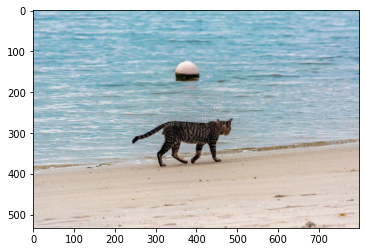

a cat walking on a beach near the water.


In [15]:
url_list = [
            "https://thumbs.dreamstime.com/b/walking-black-grey-cat-exporing-beach-blue-water-sea-background-walking-black-grey-cat-exporing-beach-blue-172573404.jpg"
            ]

# url_list.append("")

for url in url_list:
    caption = vitcap_captioning(image=url, local=False, display=True)
    print(caption)

8